Import libraries:

In [307]:
import seaborn as sns
import pylab
import numpy as np
import winsound
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.preprocessing import Binarizer
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import scipy.cluster.hierarchy as sch
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler as UnderSampler
from imblearn.over_sampling import RandomOverSampler as OverSampler
from imblearn.over_sampling import SMOTE, ADASYN

CDFs: 

In [308]:
def ABS_SHAP(df_shap,df):
    
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    corr_list = list()
    
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
        
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

Remove warnings:

In [309]:
import warnings
warnings.filterwarnings('ignore')

Parameters:

In [310]:
clusters_num = 10
estimators_num = 10
tree_depth = 10

### Clustering

Feature list:

In [311]:
feature_list = ['msisdn', 'data_tot_mb_q', 'all_call_cnt_q', 'active_days', 'all_call_dur_q'] 
feature_list.extend(['pmnt_amount_y', 'pmnt_cnt_y', 'nps_rating', 'in_sms_cnt_q', 'LTV'])

Prepare data:

In [312]:
df_cluster = pd.read_csv('data/critics_clients_join.csv')
df_cluster['LTV'] = df_cluster['active_days']*(df_cluster['pmnt_amount_y']/df_cluster['pmnt_cnt_y'])
df_cluster = df_cluster[feature_list]
df_cluster.set_index('msisdn', inplace=True)
df_cluster.dropna(inplace=True)
df_cluster.iloc[:,:].head()

,data_tot_mb_q,all_call_cnt_q,active_days,all_call_dur_q,pmnt_amount_y,pmnt_cnt_y,nps_rating,in_sms_cnt_q,LTV
msisdn,,,,,,,,,
9160911129,0.0,94,5241,10414,300.0,3,9,14,5.241000e+05
9852209265,14853.0,1727,5030,165703,37700.0,16,2,583,1.185194e+07
9161756214,32745.0,386,6579,74892,11670.0,31,10,642,2.476675e+06
9164584507,0.0,124,4979,19515,850.0,3,7,101,1.410717e+06
9151755444,85866.0,1619,1442,108686,8273.0,44,6,529,2.711288e+05


Remove outliers:

In [313]:
# Q1 = df_cluster.quantile(0.25)
# Q3 = df_cluster.quantile(0.75)
# IQR = (Q3 - Q1)
# df_cluster = df_cluster[~((df_cluster < (Q1 - 1.5 * IQR)) |(df_cluster > (Q3 + 1.5 * IQR))).any(axis=1)]

Distributions:

In [314]:
df_cluster.describe().head()

,data_tot_mb_q,all_call_cnt_q,active_days,all_call_dur_q,pmnt_amount_y,pmnt_cnt_y,nps_rating,in_sms_cnt_q,LTV
count,122579.000000,122579.000000,122579.000000,122579.000000,122579.000000,122579.000000,122579.000000,122579.000000,1.225790e+05
mean,15393.980462,632.162834,4155.674749,90416.540386,6754.630989,18.885633,7.211643,453.624340,2.002857e+06
std,35632.377218,670.490991,1708.331110,94045.563703,7432.250238,19.694263,3.413459,446.807591,3.456424e+06
min,0.000000,0.000000,36.000000,0.000000,-4093.000000,1.000000,0.000000,0.000000,-2.338000e+06
25%,0.000000,211.000000,2570.000000,26717.000000,2610.000000,9.000000,5.000000,188.000000,5.911375e+05


Correlation heatmap:

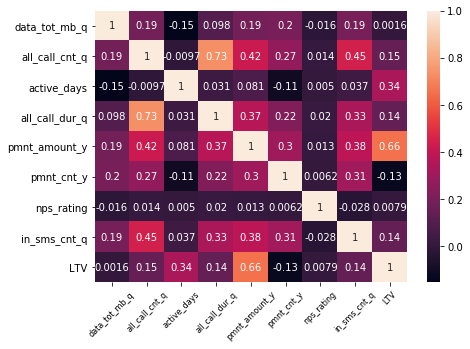

In [315]:
plt.figure(figsize=(7,5))
g = sns.heatmap(df_cluster.corr(), xticklabels=df_cluster.corr().columns, yticklabels=df_cluster.corr().columns, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 8)
plt.show()

Rename features:

In [316]:
feature_dict = {'data_tot_mb_q': 'трафик, гб/кв', 'all_call_cnt_q': 'число звонков, кв', 'age': 'возраст'} 
feature_dict.update({'active_days': 'время жизни, лет', 'all_call_dur_q': 'длительность звонков, ч/кв', 'sex': 'пол'}) 
feature_dict.update({'pmnt_cnt_y': 'число платежей, год', 'pmnt_amount_y': 'платежи за год, р', 'in_sms_cnt_q': 'смс'})
feature_dict.update({'payment': 'платеж'})
df_cluster.rename(feature_dict, axis=1, inplace=True)

df_cluster['трафик, гб/кв'] = df_cluster['трафик, гб/кв']/1000
df_cluster['время жизни, лет'] = df_cluster['время жизни, лет']/365
df_cluster['длительность звонков, ч/кв'] = df_cluster['длительность звонков, ч/кв']/365

Description:

In [317]:
df_cluster.describe().round().astype(int).T

,count,mean,std,min,25%,50%,75%,max
"трафик, гб/кв",122579,15,36,0,0,3,15,2387
"число звонков, кв",122579,632,670,0,211,447,826,31595
"время жизни, лет",122579,11,5,0,7,12,15,24
"длительность звонков, ч/кв",122579,248,258,0,73,172,335,7787
"платежи за год, р",122579,6755,7432,-4093,2610,5609,8400,806795
"число платежей, год",122579,19,20,1,9,14,22,567
nps_rating,122579,7,3,0,5,9,10,10
смс,122579,454,447,0,188,364,603,45982
LTV,122579,2002857,3456424,-2338000,591137,1262040,2439155,553380690


Add median:

In [318]:
df_median = df_cluster.describe().round().astype(int).loc[['50%'],:].reset_index(drop=True)
df_median['объем кластера']=len(df_cluster)

Rescale fetures:

In [319]:
df_cluster = (df_cluster - df_cluster.min())/(df_cluster.max() - df_cluster.min())

Hierarchical clustering:

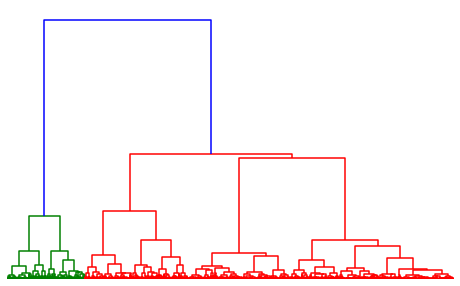

In [320]:
X = df_cluster.sample(frac=0.2, random_state=7).values
fig = pylab.figure(figsize=(8,5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), get_leaves=False, show_leaf_counts=False)
plt.axis('off')
fig.show()

Lifetime-payments:

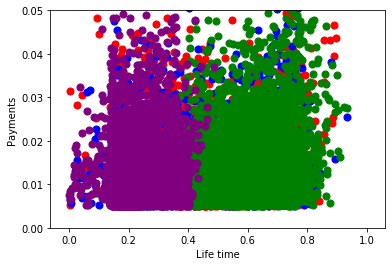

In [321]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

plt.scatter(X[labels==0, 2], X[labels==0, 4], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 2], X[labels==1, 4], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 2], X[labels==2, 4], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 2], X[labels==3, 4], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 2], X[labels==4, 4], s=50, marker='o', color='orange')

plt.xlabel('Life time')
plt.ylabel('Payments')

plt.ylim(0,0.05)
plt.show()

K-means clustering:

In [322]:
X = df_cluster.values
wcss = []

for i in range(2, clusters_num+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=4, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print('Iteration:', i)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


Plot Within-Cluster-Sum-of-Squares curve: 

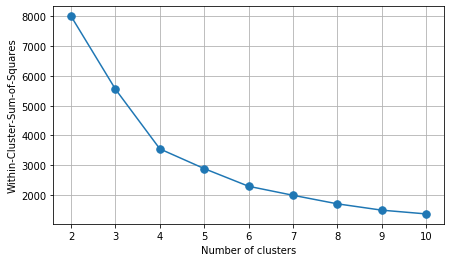

In [323]:
plt.figure(figsize=(7,4))
plt.plot(range(2, clusters_num+1), wcss, '.-', markersize=15)

plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster-Sum-of-Squares')

plt.grid()
plt.show()

Multiple clusters:

In [324]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=clusters_num, random_state=0)
cluster_analysis = kmeans.fit_predict(X)

Create cluster dataframe:

In [325]:
df_cluster_profiles = pd.DataFrame(data=kmeans.cluster_centers_, columns=df_cluster.columns)
df_cluster_profiles.index.names = ['#']

Add cluster power:

In [326]:
df_power = pd.DataFrame(dict(Counter(kmeans.labels_)).items(), columns=['#', 'объем кластера'])
df_cluster_power = pd.merge(df_cluster_profiles, df_power, how='inner', on=['#', '#'])
df_cluster_power['nps_rating'] = df_cluster_power['nps_rating']
df_cluster_power.drop(['#'], axis=1, inplace=True)
df_cluster_power.iloc[:,:].head()

,"трафик, гб/кв","число звонков, кв","время жизни, лет","длительность звонков, ч/кв","платежи за год, р","число платежей, год",nps_rating,смс,LTV,объем кластера
0,0.008691,0.020931,0.267982,0.031754,0.012903,0.035886,0.952302,0.009412,0.005845,32896
1,0.004766,0.018607,0.624893,0.030878,0.013365,0.027293,0.481204,0.010489,0.009239,11921
2,0.004197,0.020063,0.619269,0.033280,0.013874,0.029057,0.981687,0.009509,0.009293,34996
3,0.005302,0.019102,0.618463,0.031403,0.014039,0.028357,0.768204,0.010961,0.009503,12947
4,0.009348,0.021275,0.273142,0.031745,0.013110,0.037347,0.069571,0.010490,0.005888,9369


Merge cluster centers with input dataframe:

In [327]:
cluster_map = pd.DataFrame()
cluster_map['msisdn'] = df_cluster.index.values
cluster_map['cluster'] = kmeans.labels_
df_merged = pd.merge(df_cluster, cluster_map,  how='inner', left_on=['msisdn'], right_on = ['msisdn'])
df_merged.head()

,msisdn,"трафик, гб/кв","число звонков, кв","время жизни, лет","длительность звонков, ч/кв","платежи за год, р","число платежей, год",nps_rating,смс,LTV,cluster
0,9160911129,0.000000,0.002975,0.591948,0.003664,0.005418,0.003534,0.9,0.000304,0.005150,2
1,9852209265,0.006222,0.054661,0.567952,0.058299,0.051540,0.026502,0.2,0.012679,0.025534,5
2,9161756214,0.013718,0.012217,0.744115,0.026349,0.019439,0.053004,1.0,0.013962,0.008664,2
3,9164584507,0.000000,0.003925,0.562152,0.006866,0.006096,0.003534,0.7,0.002197,0.006746,3
4,9151755444,0.035971,0.051242,0.159900,0.038239,0.015250,0.075972,0.6,0.011505,0.004695,6


Plot clusters:

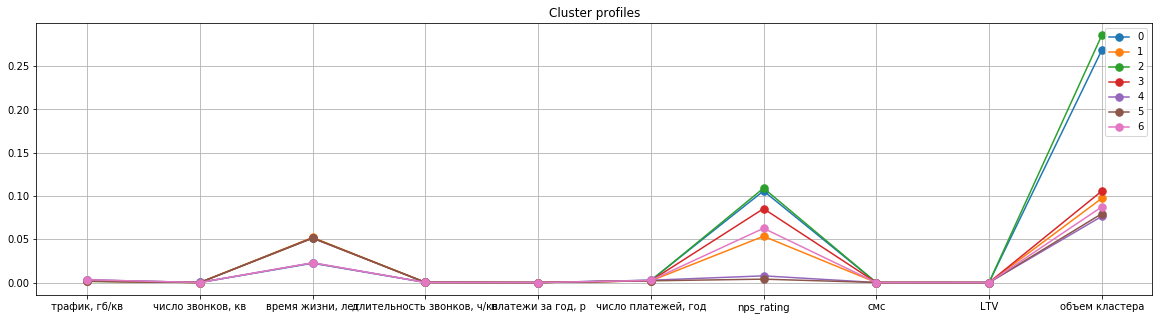

In [328]:
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(figsize=(20,5))

for i in range(7):
    plt.plot(df_cluster_power.columns, df_cluster_power_norm.iloc[i], '.-', markersize=15, color=colors[i], label=(i))  
    
plt.legend(loc='upper right')
plt.title('Cluster profiles')
plt.grid(True)
plt.show()

Write to xls:

In [329]:
df_merged.to_excel('data/cluster_msisdn.xlsx', sheet_name='First', index=True)

### Factor analysis

Select cluster:

In [330]:
# msisdn_list = list(set(df_merged[df_merged['cluster']==3]['msisdn'].values))
# print('Cluster volume:', len(msisdn_list))

Drop list:

In [331]:
dl = ['is_active_flg', 'nps_rating', 'msisdn']
dl.extend(['roam_region_cnt_y'])

Import data:

In [332]:
df = pd.read_csv('data/critics_clients_join.csv') 
# df = df[df['msisdn'].isin(msisdn_list)]
df = df[df['is_active_flg']==1]
df['score'] = df['nps_rating']
df.drop(dl, axis=1, inplace=True)
df.dropna(inplace=True)
df = df[df['pmnt_cnt_y'] > 0]
df.iloc[:,:5].head()

,active_days,tp_group,all_call_dur_q,data_tot_mb_q,pmnt_amount_y
0,5241,17,10414,0.0,300.0
1,5030,408,165703,14853.0,37700.0
2,6579,409,74892,32745.0,11670.0
3,4979,261,19515,0.0,850.0
4,1442,365,108686,85866.0,8273.0


Encode categorial features:

In [333]:
cat_features = ['sex', 'con_typ', 'sales_channel', 'region', 'tp_group', 'mcat_business'] 
df[cat_features] = df[cat_features].applymap(lambda x: hash(x) % 100)

Prepare target:

In [334]:
df['score_bin'] = df['score'] <= np.median(df['score'])
del df['score']
array = df.values
X = array[:,0:(len(df.columns)-1)]
Y = array[:,(len(df.columns)-1)].reshape(-1, 1).astype(int)
X, Y = UnderSampler().fit_resample(X, Y)
print('Resampled dataset shape: %s' % Counter(Y))

Resampled dataset shape: Counter({0: 48402, 1: 48402})


Define roc_auc:

      Iter       Train Loss   Remaining Time 
         1           1.3603            5.41s
         2           1.3381            4.81s
         3           1.3174            4.30s
         4           1.2985            3.68s
         5           1.2811            3.09s
         6           1.2657            2.43s
         7           1.2505            1.79s
         8           1.2349            1.18s
         9           1.2212            0.58s
        10           1.2084            0.00s

No Skill: ROC AUC=0.500
Skilled: ROC AUC=0.605


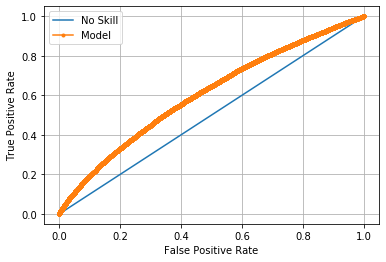

In [335]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.5, random_state=2)

model = GradientBoostingClassifier(n_estimators=estimators_num, random_state=7, max_depth=tree_depth, verbose=1) 
ns_probs = [0 for _ in range(len(testy))]
model.fit(trainX, trainy)

lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

print('\nNo Skill: ROC AUC=%.3f' % (ns_auc))
print('Skilled: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='-', label='No Skill', markersize=3)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.grid()
plt.legend()
plt.show()

Compare algos:

In [343]:
scoring='accuracy'

models, results = [], []
names = []

models.append(('GBC', GradientBoostingClassifier(n_estimators=estimators_num, random_state=7, max_depth=tree_depth)))
models.append(('XGBC', xgb.XGBClassifier(random_state=7, max_depth=tree_depth))) 
models.append(('LR', LogisticRegression(solver='newton-cg')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

for name, model in models:
    
    kfold = StratifiedKFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
winsound.Beep(440, 1000)

GBC: 0.582455 (0.004436)
XGBC: 0.590275 (0.005060)
LR: 0.577414 (0.003191)
LDA: 0.575813 (0.003570)
KNN: 0.520888 (0.002169)
CART: 0.523739 (0.003303)
NB: 0.541011 (0.007908)


Ensemble test:

In [351]:
scoring='accuracy'
kfold = StratifiedKFold(n_splits=10, random_state=7)

models = []
models.append(('LR', LogisticRegression(solver='newton-cg')))
models.append(('XGBC', xgb.XGBClassifier(random_state=7, max_depth=tree_depth)))
models.append(('GBC', GradientBoostingClassifier(n_estimators=estimators_num, random_state=7, max_depth=tree_depth)))

ensemble = VotingClassifier(estimators, voting='hard')
cv_results = cross_val_score(ensemble, X, Y, cv=kfold, scoring=scoring, n_jobs=-1, verbose=1) 
print('%s: %f (%f)' % ('Score', cv_results.mean(), cv_results.std()), '\n')

winsound.Beep(440, 1000)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


Score: 0.586164 (0.005271) 



Bagging test:

In [ ]:
scoring='accuracy'
kfold = StratifiedKFold(n_splits=10, random_state=7)

models = []
models.append(('LR', LogisticRegression(solver='newton-cg')))
models.append(('XGBC', xgb.XGBClassifier(random_state=7, max_depth=tree_depth)))
models.append(('GBC', GradientBoostingClassifier(n_estimators=estimators_num, random_state=7, max_depth=tree_depth)))

ensemble = VotingClassifier(estimators, voting='hard')
model = BaggingClassifier(base_estimator=ensemble, n_estimators=estimators_num, random_state=7)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=-1, verbose=1) 

print('%s: %f (%f)' % ('Score', cv_results.mean(), cv_results.std()), '\n')
winsound.Beep(440, 1000)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Hold out metrics:

In [339]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

model = xgb.XGBClassifier(random_state=7, max_depth=tree_depth)
model.fit(X_train, Y_train)

predicted = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

precision = float(precision_score(Y_test, predicted))
recall = float(recall_score(Y_test, predicted))
f1 = float(f1_score(Y_test, predicted))

print('\nHold-out precision:', round(precision*100), '%')
print('Hold-out recall:', round(recall*100), '%')
print('Hold-out F1:', round(f1*100), '%')


Hold-out precision: 59 %
Hold-out recall: 56 %
Hold-out F1: 58 %


Shap values:

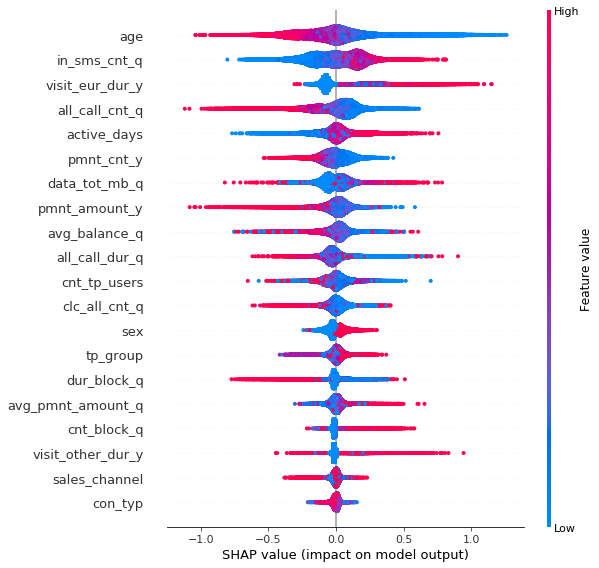

In [340]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=df.loc[:, df.columns != 'score'].columns)
winsound.Beep(440, 1000)